In [ ]:
#@title Check GPU
!nvidia-smi

Fri Nov 18 15:04:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title Installs
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

     |████████████████████████████████| 5.5 MB 4.8 MB/s 
     |████████████████████████████████| 451 kB 87.7 MB/s 
     |████████████████████████████████| 118 kB 89.2 MB/s 
     |████████████████████████████████| 65 kB 5.0 MB/s 
     |████████████████████████████████| 182 kB 92.8 MB/s 
     |████████████████████████████████| 115 kB 78.3 MB/s 
     |████████████████████████████████| 212 kB 93.9 MB/s 
     |████████████████████████████████| 127 kB 88.7 MB/s 
     |████████████████████████████████| 50 kB 7.7 MB/s 
     |████████████████████████████████| 93 kB 2.4 MB/s 
     |████████████████████████████████| 138 kB 85.3 MB/s 
     |████████████████████████████████| 357 kB 91.0 MB/s 
     |████████████████████████████████| 2.3 MB 76.4 MB/s 
     |████████████████████████████████| 379 kB 79.9 MB/s 
     |████████████████████████████████| 7.6 MB 51.0 MB/s 
     |████████████████████████████████| 1.3 MB 60.7 MB/s 


In [ ]:
#@title Imports
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt

import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

from google.colab import drive
drive.mount('/content/drive')

nltk.download("punkt")

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# from datasets import load_dataset

In [ ]:
#@title Pretrained Pegasus on CNN/Dailymail
device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

In [ ]:
#@title Functions for Batching and Calculating Metrics
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def calculate_metric_on_test_ds(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, 
                         num_beams=8, 
                         max_length=50, 
                         no_repeat_ngram_size=4)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
        
        # Finally, we decode the generated texts, 
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]      
        
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        
        
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

### [amazon_us_reviews-Videos Dataset](https://https://huggingface.co/datasets/amazon_us_reviews/viewer/Video_v1_00/train)

In [ ]:
#@title Load Dataset
dataset_amazon = load_dataset("amazon_us_reviews", 'Video_v1_00')

Generating train split:   0%|          | 0/380604 [00:00<?, ? examples/s]

Dataset amazon_us_reviews downloaded and prepared to /root/.cache/huggingface/datasets/amazon_us_reviews/Video_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#@title Look at Data
split_lengths = [len(dataset_amazon[split])for split in dataset_amazon]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_amazon['train'].column_names}")
print("\nReview Body:")

print(dataset_amazon["train"][0]["review_body"])

print("\nHeadline:")

print(dataset_amazon["train"][0]["review_headline"])

Split lengths: [380604]
Features: ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date']

Review Body:
Fast shipping. Pleasure to deal with. Would recommend. A+++. Thanks!

Headline:
Very satisfied!!


### Evaluating PEGASUS on Amazon Reviews

In [ ]:
pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(dataset_amazon['train'][0]['review_body'] )

print(pipe_out)

Your max_length is set to 128, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


[{'summary_text': 'Fast shipping. Pleasure to deal with. A+++. Thanks!<n>Fast shipping. Pleasure to deal with. A+++.<n>Thanks!<n>Fast shipping. Pleasure to deal with. A+++.'}]


In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(dataset_amazon['train'][:10000], rouge_metric, model_pegasus, tokenizer, column_text = 'review_body', column_summary='review_headline', batch_size=8 )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  This is separate from the ipykernel package so we can avoid doing imports until


100%|██████████| 1250/1250 [3:57:32<00:00, 11.40s/it]


In [ ]:
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.002989,0.000083,0.002983,0.002981


In [ ]:
model_pegasus.generate()

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 128 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


tensor([[  0, 110, 107, 106, 110, 107, 106, 110, 107, 106, 110, 107, 106, 110,
         107, 106, 110, 107, 106, 110, 107, 106, 110, 107, 106, 110, 107, 106,
         110, 107, 106, 110, 107,   1]], device='cuda:0')

### Explore Data and Plot Histogram

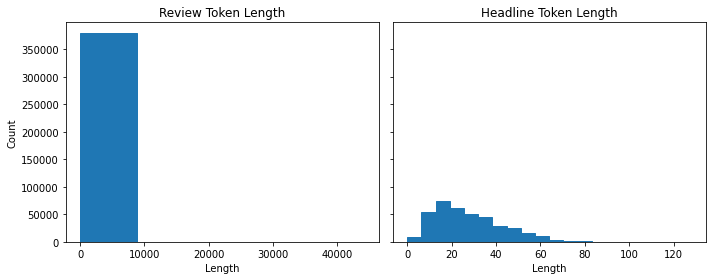

In [ ]:
#@title Review and Headline Length
review_len = [len(s) for s in dataset_amazon['train']['review_body']]

headline_len = [len(s) for s in dataset_amazon['train']['review_headline']]
# review_len = [len(s) for s in dataset_amazon['train'][:10000]['review_body']]

# headline_len = [len(s) for s in dataset_amazon['train'][:10000]['review_headline']]


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='all' )
axes[0].hist(review_len, bins = 5, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Review Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(headline_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Headline Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

Majority of reviews have < 10,000 words, some extend to over 40,000. Let's remove the reviews with length > 10k.

In [ ]:
count = 0
for review in dataset_amazon['train']['review_body']:
  if len(review) > 1024:
    count +=1
print(count)

79372


In [ ]:
#@title Create DataFrame
amazon_train_df = pd.DataFrame(dataset_amazon['train'])
print(amazon_train_df.shape)
amazon_train_df.head()

(380604, 15)


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,49033728,R1P1G5KZ05H6RD,6302503213,748506413,The Night They Saved Christmas [VHS],Video,5,0,0,0,1,Very satisfied!!,Fast shipping. Pleasure to deal with. Would re...,2015-08-31
1,US,17857748,R106N066IUN8ZV,B000059PET,478710180,"Hamlet / Kline, New York Shakespeare Festival ...",Video,5,0,0,0,1,The most talented actor ever!,"Kevin Kline is the most versatile, multi-talen...",2015-08-31
2,US,25551507,R7WTAA1S5O7D9,0788812807,981002815,Nascar Dual Powered Calculator (Solar & Batter...,Video,4,0,0,0,1,Four Stars,great movie,2015-08-31
3,US,21025041,R32HFMVWLYOYJK,6302509939,333219811,"The Man From U.N.C.L.E, Volume 19: The Brain K...",Video,5,0,0,0,1,Five Stars,i love the martin landau episode,2015-08-31
4,US,40943563,RWT3H6HBVAL6G,B00JENS2BI,538101194,Playboy Video Party Jokes [VHS],Video,3,0,0,0,0,"HOT women, dumb jokes",Y'know what this reminded me of? Those sketch ...,2015-08-31


In [ ]:
#@title Keep necessary columns
amazon_train_df = amazon_train_df[['review_headline','review_body']]
print(amazon_train_df.shape)
amazon_train_df.head()

(380604, 2)


,review_headline,review_body
0,Very satisfied!!,Fast shipping. Pleasure to deal with. Would re...
1,The most talented actor ever!,"Kevin Kline is the most versatile, multi-talen..."
2,Four Stars,great movie
3,Five Stars,i love the martin landau episode
4,"HOT women, dumb jokes",Y'know what this reminded me of? Those sketch ...


In [ ]:
#@title Filter Reviews with length > 1024
mask = (amazon_train_df['review_body'].str.len() <= 1024) 
amazon_train_df = amazon_train_df.loc[mask]
print(amazon_train_df.shape)
amazon_train_df.head()

(301232, 2)


,review_headline,review_body
0,Very satisfied!!,Fast shipping. Pleasure to deal with. Would re...
1,The most talented actor ever!,"Kevin Kline is the most versatile, multi-talen..."
2,Four Stars,great movie
3,Five Stars,i love the martin landau episode
4,"HOT women, dumb jokes",Y'know what this reminded me of? Those sketch ...


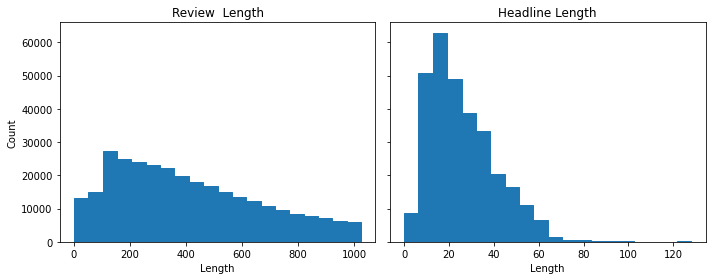

In [ ]:
#@title Review Filtered Length
review_len = [len(s) for s in amazon_train_df['review_body']]

headline_len = [len(s) for s in amazon_train_df['review_headline']]
# review_len = [len(s) for s in dataset_amazon['train'][:10000]['review_body']]

# headline_len = [len(s) for s in dataset_amazon['train'][:10000]['review_headline']]


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='all' )
axes[0].hist(review_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Review  Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(headline_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Headline Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

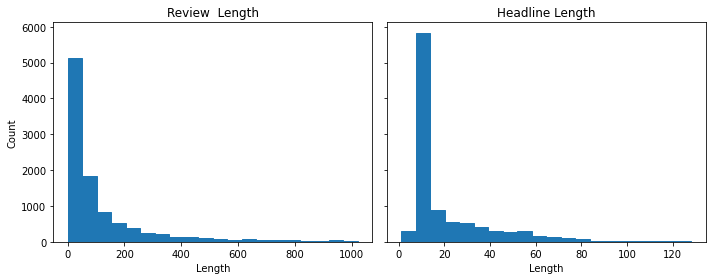

In [ ]:
#@title Review Filtered Length first 10,000 records
review_len = [len(s) for s in amazon_train_df[:10000]['review_body']]

headline_len = [len(s) for s in amazon_train_df[:10000]['review_headline']]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='all' )
axes[0].hist(review_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Review  Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(headline_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Headline Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

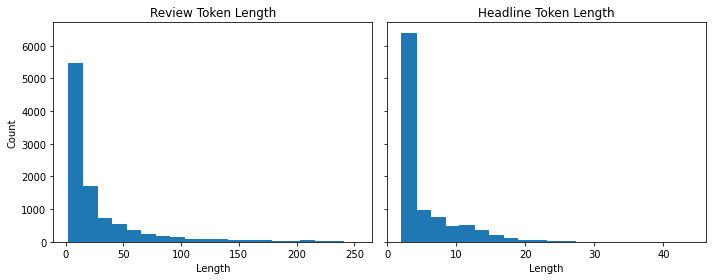

In [ ]:
#@title Review and Headline Token Length of Trimmed Dataset First 10,000 Records

review_token_len = [len(tokenizer.encode(s, max_length=1024, truncation = True)) for s in amazon_train_df[:10000]['review_body']]

headline_token_len = [len(tokenizer.encode(s, max_length = 128, truncation = True)) for s in amazon_train_df[:10000]['review_headline']]


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='all' )
axes[0].hist(review_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Review Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(headline_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Headline Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

### Split Data Train/Validation/Test

In [ ]:
type(dataset_amazon)

datasets.dataset_dict.DatasetDict

In [ ]:
import datasets
# type(datasets.Dataset.from_dict(amazon_train_df))


In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['review_body'] , max_length = 1024, truncation = True )
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['review_headline'], max_length = 128, truncation = True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }
  
#Update below code with trimmed dataset name before mapping
amazon_train_dataset = datasets.Dataset.from_dict(amazon_train_df)
dataset_amazon_pt = amazon_train_dataset.map(convert_examples_to_features, batched = True)
# dataset_amazon_pt = amazon_train_df.map(convert_examples_to_features, batched = True)

  0%|          | 0/302 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3547: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "


In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [ ]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='gdrive/MyDrive/pegasus-amazon2/pegasus-amazon2', 
    num_train_epochs=5, 
    warmup_steps=500,
    per_device_train_batch_size=32, 
    per_device_eval_batch_size=32,
    weight_decay=0.01, 
    logging_steps=10,
    evaluation_strategy='steps', 
    eval_steps=500, 
    save_steps=1e6,
    gradient_accumulation_steps=16,
    save_strategy='epoch'
) 

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#@title Split PT Dataset
# 70% train, 30% test + validation
train_testvalid = dataset_amazon_pt.train_test_split(test_size=0.3)
# Split the 20% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
train_test_valid_dataset = datasets.DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [ ]:
train_test_valid_dataset

DatasetDict({
    train: Dataset({
        features: ['review_headline', 'review_body', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 210862
    })
    test: Dataset({
        features: ['review_headline', 'review_body', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 45185
    })
    valid: Dataset({
        features: ['review_headline', 'review_body', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 45185
    })
})

In [ ]:
train_test_valid_dataset['train']

Dataset({
    features: ['review_headline', 'review_body', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 210862
})

In [ ]:
#@title Split amazon_train_dataset
# 70% train, 30% test + validation
amazon_train_testvalid = amazon_train_dataset.train_test_split(test_size=0.3)
# Split the 20% test + valid in half test, half valid
amazon_test_valid = amazon_train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
amazon_train_test_valid_dataset = datasets.DatasetDict({
    'train': amazon_train_testvalid['train'],
    'test': amazon_test_valid['test'],
    'valid': amazon_test_valid['train']})

In [ ]:
amazon_train_test_valid_dataset['train']

Dataset({
    features: ['review_headline', 'review_body'],
    num_rows: 210862
})

### Train Pegasus on Amazon Data

In [ ]:
#@title Create Trainer
trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=train_test_valid_dataset['train'], 
                  eval_dataset=train_test_valid_dataset['valid'])

In [ ]:
#@title Train Model with Amazon Data
trainer.train()

# score = calculate_metric_on_test_ds(
#     train_test_valid_dataset['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'review_body', column_summary= 'review_headline'
# )

# rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

# pd.DataFrame(rouge_dict, index = [f'pegasus'] )

The following columns in the training set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: review_headline, review_body. If review_headline, review_body are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 210862
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 512
  Gradient Accumulation steps = 16
  Total optimization steps = 2055
  Number of trainable parameters = 568699904
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenize

Step,Training Loss,Validation Loss
500,3.509700,3.358257
1000,3.349400,3.244680
1500,3.283900,3.208607
2000,3.227300,3.197337


Saving model checkpoint to gdrive/MyDrive/pegasus-amazon2/pegasus-amazon2/checkpoint-411
Configuration saved in gdrive/MyDrive/pegasus-amazon2/pegasus-amazon2/checkpoint-411/config.json
Model weights saved in gdrive/MyDrive/pegasus-amazon2/pegasus-amazon2/checkpoint-411/pytorch_model.bin
tokenizer config file saved in gdrive/MyDrive/pegasus-amazon2/pegasus-amazon2/checkpoint-411/tokenizer_config.json
Special tokens file saved in gdrive/MyDrive/pegasus-amazon2/pegasus-amazon2/checkpoint-411/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: review_headline, review_body. If review_headline, review_body are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 45185
  Batch size = 32
Saving model checkpoint to gdrive/MyDrive/pegasus-amazon2/pegasus-amazon2/checkpoint-822
Configurat

TrainOutput(global_step=2055, training_loss=3.503660056306788, metrics={'train_runtime': 27681.5732, 'train_samples_per_second': 38.087, 'train_steps_per_second': 0.074, 'total_flos': 6.604847693088031e+17, 'train_loss': 3.503660056306788, 'epoch': 5.0})

In [ ]:
#@title Save Model
trainer.save_model('drive/MyDrive/model_weights/pegasus-amazon2/')

Saving model checkpoint to drive/MyDrive/model_weights/pegasus-amazon2/
Configuration saved in drive/MyDrive/model_weights/pegasus-amazon2/config.json
Model weights saved in drive/MyDrive/model_weights/pegasus-amazon2/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/model_weights/pegasus-amazon2/tokenizer_config.json
Special tokens file saved in drive/MyDrive/model_weights/pegasus-amazon2/special_tokens_map.json


In [ ]:
trainer.save_model()

Saving model checkpoint to gdrive/MyDrive/pegasus-amazon2/pegasus-amazon2
Configuration saved in gdrive/MyDrive/pegasus-amazon2/pegasus-amazon2/config.json
Model weights saved in gdrive/MyDrive/pegasus-amazon2/pegasus-amazon2/pytorch_model.bin
tokenizer config file saved in gdrive/MyDrive/pegasus-amazon2/pegasus-amazon2/tokenizer_config.json
Special tokens file saved in gdrive/MyDrive/pegasus-amazon2/pegasus-amazon2/special_tokens_map.json


In [ ]:
!ls

drive  gdrive  sample_data


In [ ]:
trainer.save_model('gdrive/MyDrive/model_weights/pegasus-amazon2/model2')

In [ ]:
# !cp -r pegasus-amazon /content/drive/MyDrive/

### Evaluate New Model

In [ ]:
#@title Load Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_ckpt = 'drive/MyDrive/model_weights/pegasus-amazon2'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
trainer = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [ ]:
model_ckpt = 'drive/MyDrive/model_weights/pegasus-amazon2'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
trainer = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

loading file spiece.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file drive/MyDrive/model_weights/pegasus-amazon2/config.json
Model config PegasusConfig {
  "_name_or_path": "drive/MyDrive/model_weights/pegasus-amazon2",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "PegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 0,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "extra_pos_embeddings": 1,
  "forced_eos_token_id": 1,
  "id

In [ ]:
trainer.generate()

AttributeError: ignored

In [ ]:
pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(dataset_amazon['train'][0]['review_body'] )

print(pipe_out)

loading configuration file drive/MyDrive/model_weights/pegasus-amazon2/config.json
Model config PegasusConfig {
  "_name_or_path": "drive/MyDrive/model_weights/pegasus-amazon2",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "PegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 0,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "extra_pos_embeddings": 1,
  "forced_eos_token_id": 1,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0

[{'summary_text': 'Fast shipping and Pleasure to deal with. Would recommend. A+++ Thanks! Thanks! Fast shipping and Pleasure to deal with. Would recommend. Would recommend.'}]


In [ ]:
#@title Determine Rouge Scores of New Model
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(
    train_test_valid_dataset['test'], rouge_metric, trainer, tokenizer, batch_size = 2, column_text = 'review_body', column_summary= 'review_headline'
)
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )

100%|██████████| 22593/22593 [7:34:02<00:00,  1.21s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.005035,0.000102,0.005022,0.005019


### Generating Highlights

In [ ]:

gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 50}

sample_text = amazon_train_test_valid_dataset["test"][0]["review_body"]

reference = amazon_train_test_valid_dataset["test"][0]["review_headline"]

model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to('cpu')

pipe = pipeline("summarization", model=model, tokenizer = tokenizer)

## 
print("Review Body:")
print(sample_text)


print("\nReference Highlight:")
print(reference)


print("\nModel Highlight:")
print(pipe(amazon_train_test_valid_dataset['test'][0]['review_body'], **gen_kwargs)[0]["summary_text"])

loading configuration file drive/MyDrive/model_weights/pegasus-amazon2/config.json
Model config PegasusConfig {
  "_name_or_path": "drive/MyDrive/model_weights/pegasus-amazon2",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "PegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 0,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "extra_pos_embeddings": 1,
  "forced_eos_token_id": 1,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0

Review Body:
All in this video are greatie: Battle,. W.Maersalis, F.VonStade.  A must for Xmas viewing and sharing especially Xmas eve.

Reference Highlight:
A must for Xmas for Classical Soprano Lovers .All in this f

Model Highlight:
A must for Xmas viewing and sharing especially Xmas eve. A must for Xmas viewing and sharing especially Xmas eve. A must for Xmas viewing and sharing especially Xmas eve.
